In [1]:
import lab
import gpflow as gp
import math
import scipy.fft
import numpy as np
import time
from matplotlib import pyplot as plt
import seaborn
import json

import sys, importlib, pathlib
sys.path.insert(0, str(pathlib.Path().resolve().parent))

seaborn.set()
seaborn.set_style('whitegrid') # use whitegrid for print-ready plots

lab.default_dtype=np.float64

import vff
plt.rcParams.update({'figure.figsize' : (8, 6),
                     # bigger labels for readability
                    'font.size' : 22,
                    'axes.labelsize' : 28,
                    'xtick.labelsize' : 22,
                    'ytick.labelsize' : 22,
                     'axes.titlesize' : 28,
                     # Latex-like fonts
                     'text.usetex' : True,
                     'font.family' : 'serif',
                     'font.serif' : 'Computer Modern',
                     'mathtext.fontset' : 'cm',
                     'mathtext.rm' : 'Bitstream Vera Sans',
                     'mathtext.it' : 'Bitstream Vera Sans:italic',
                     'mathtext.bf' : 'Bitstream Ver Sans:bold',
                      'lines.linewidth' : 3,
                    })



2023-01-26 19:40:33.656034: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-26 19:40:34.219435: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-26 19:40:34.219557: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-26 19:40:34.219577: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

First straightforward priors, gp, samples

2023-01-26 06:50:26.119968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 06:50:26.125274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 06:50:26.125464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 06:50:26.126013: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

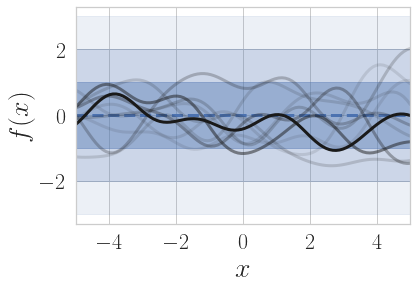

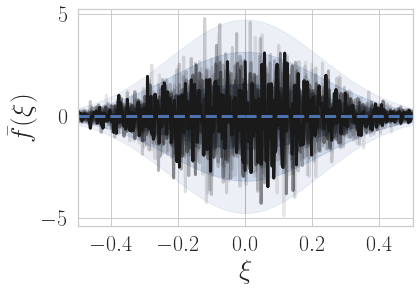

In [2]:
num_samples = 10

# fix the seeds for reproducible figures
seed = 7
np.random.seed(seed)
lab.set_random_seed(seed)


k = gp.kernels.SquaredExponential()

x = lab.expand_dims(lab.linspace(-5, 5, 100), axis=-1)
freqs = lab.expand_dims(lab.linspace(0.0001, .5, 200), axis=-1)
ys = []
w_plus = []
w_min = []

for i in range(num_samples):
    w_plus = w_plus + [lab.expand_dims(lab.sqrt(vff.objectives.gaussian_spectral_density(k, freqs)) 
                               * lab.randn(freqs.shape[0]), axis=-1)]
    w_min = w_min + [lab.expand_dims(lab.sqrt(vff.objectives.gaussian_spectral_density(k, freqs)) 
                               * lab.randn(freqs.shape[0]), axis=-1)]
    w_cos = (w_plus[-1] + w_min[-1])/2
    w_sin = (w_plus[-1] - w_min[-1])/2
    ys = ys + [lab.sum(w_cos*lab.cos(2*math.pi*freqs*lab.squeeze(x)) 
                           + w_sin*lab.sin(2*math.pi*freqs*lab.squeeze(x)), axis=0)/lab.sqrt(freqs.shape[0])]
    
# plot mean and confidences
std = lab.sqrt(k.K_diag(x))
seaborn.lineplot(x=lab.squeeze(x), y=lab.zeros(x.shape[0]), color='b', linestyle='dashed')
plt.fill_between(x=lab.squeeze(x), y1=-std, y2=std, color='b', alpha=0.4)
plt.fill_between(x=lab.squeeze(x), y1=-2*std, y2=+2*std, color='b', alpha=0.2)
plt.fill_between(x=lab.squeeze(x), y1=-3*std, y2=+3*std, color='b', alpha=0.1)


for i in range(num_samples):
    seaborn.lineplot(x=lab.squeeze(x), y=ys[i], color='k', alpha=1/(i+1))
plt.xlim(x.min(), x.max())
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
plt.savefig('../images/prior_x.png', bbox_inches="tight")
plt.show()
plt.clf()

# plot mean and confidences
std = lab.sqrt(vff.objectives.gaussian_spectral_density(k, freqs))

for i in range(num_samples):
    seaborn.lineplot(x=-lab.squeeze(freqs), y=lab.squeeze(w_min[i]), color='k', alpha=1/(i+1))
    seaborn.lineplot(x=lab.squeeze(freqs), y=lab.squeeze(w_plus[i]), color='k', alpha=1/(i+1))
seaborn.lineplot(x=lab.squeeze(freqs), y=lab.zeros(freqs.shape[0]), color='b', linestyle='dashed')
plt.fill_between(x=lab.squeeze(freqs), y1=-std, y2=std, color='b', alpha=0.4)
plt.fill_between(x=lab.squeeze(freqs), y1=-2*std, y2=+2*std, color='b', alpha=0.2)
plt.fill_between(x=lab.squeeze(freqs), y1=-3*std, y2=+3*std, color='b', alpha=0.1)
seaborn.lineplot(x=-lab.squeeze(freqs), y=lab.zeros(freqs.shape[0]), color='b', linestyle='dashed')
plt.fill_between(x=-lab.squeeze(freqs), y1=-std, y2=std, color='b', alpha=0.4)
plt.fill_between(x=-lab.squeeze(freqs), y1=-2*std, y2=+2*std, color='b', alpha=0.2)
plt.fill_between(x=-lab.squeeze(freqs), y1=-3*std, y2=+3*std, color='b', alpha=0.1)

plt.xlim(-freqs.max(), freqs.max())
plt.xlabel(r'$\xi$')
plt.ylabel(r'$\bar{f}(\xi)$')
plt.savefig('../images/prior_xi.png', bbox_inches="tight")


conditioning on inducing freqs

In [3]:
data = lab.sin(2*math.pi*0.1 * x) - lab.cos(2*math.pi*0.2 * x)

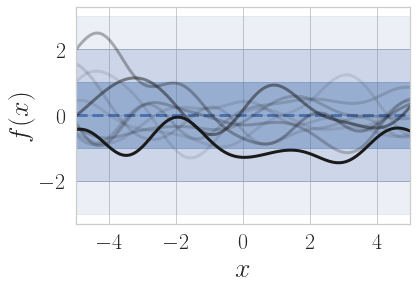

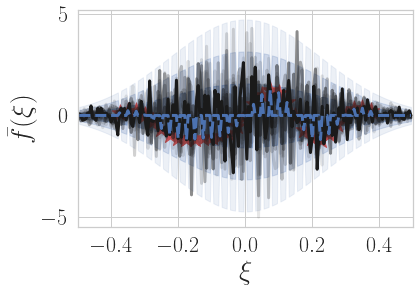

In [4]:
num_samples = 10
stride = 100
cut = 400

k = gp.kernels.SquaredExponential()

x = lab.expand_dims(lab.linspace(-5, 5, 100), axis=-1)
freqs = lab.expand_dims(lab.linspace(0.0001, .5, 2000), axis=-1)
z = freqs[0:-cut:stride, :]
feats_cos = lab.cos(2*math.pi*z  *lab.squeeze(x))/lab.sqrt(freqs.shape[0])
feats_sin = lab.sin(2*math.pi*z * lab.squeeze(x))/lab.sqrt(freqs.shape[0])
v_cos = lab.sum(feats_cos * lab.squeeze(data), axis=-1)
v_sin = lab.sum(feats_sin * lab.squeeze(data), axis=-1)
ys = []
w_plus = []
w_min = []

for i in range(num_samples):
    w_plus = w_plus + [lab.to_numpy(lab.expand_dims(lab.sqrt(vff.objectives.gaussian_spectral_density(k, freqs)) 
                               * lab.randn(freqs.shape[0]), axis=-1))]
    w_plus[-1][0:-cut:stride, 0] = lab.squeeze(v_cos + v_sin)
    w_min = w_min + [lab.to_numpy(lab.expand_dims(lab.sqrt(vff.objectives.gaussian_spectral_density(k, freqs)) 
                               * lab.randn(freqs.shape[0]), axis=-1))]
    w_min[-1][0:-cut:stride, 0] = lab.squeeze(v_cos - v_sin)
    w_cos = (w_plus[-1] + w_min[-1])/2
    w_sin = (w_plus[-1] - w_min[-1])/2
    ys = ys + [lab.sum(w_cos*lab.cos(2*math.pi*freqs*lab.squeeze(x)) 
                           + w_sin*lab.sin(2*math.pi*freqs*lab.squeeze(x)), axis=0)/lab.sqrt(freqs.shape[0])]
    
# plot mean and confidences
std = lab.sqrt(k.K_diag(x))
seaborn.lineplot(x=lab.squeeze(x), y=lab.zeros(x.shape[0]), color='b', linestyle='dashed')
plt.fill_between(x=lab.squeeze(x), y1=-std, y2=std, color='b', alpha=0.4)
plt.fill_between(x=lab.squeeze(x), y1=-2*std, y2=+2*std, color='b', alpha=0.2)
plt.fill_between(x=lab.squeeze(x), y1=-3*std, y2=+3*std, color='b', alpha=0.1)


for i in range(num_samples):
    seaborn.lineplot(x=lab.squeeze(x), y=ys[i], color='k', alpha=1/(i+1))
plt.xlim(x.min(), x.max())
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
plt.savefig('../images/cond_x.png', bbox_inches="tight")

plt.show()
plt.clf()

# plot mean and confidences
std = lab.to_numpy(lab.sqrt(vff.objectives.gaussian_spectral_density(k, freqs)))
std[0:-cut:stride] = lab.zeros(z.shape[0])
std = std[::20]
mean_plus = lab.zeros(freqs.shape[0])
mean_minus = lab.zeros(freqs.shape[0])
mean_plus[0:-cut:stride] = lab.squeeze(v_cos + v_sin)
mean_minus[0:-cut:stride] = lab.squeeze(v_cos - v_sin)
mean_plus = mean_plus[::20]
mean_minus = mean_minus[::20]


for i in range(num_samples):
    seaborn.lineplot(x=-lab.squeeze(freqs)[::20], y=lab.squeeze(w_min[i])[::20], color='k', alpha=1/(i+1))
    seaborn.lineplot(x=lab.squeeze(freqs)[::20], y=lab.squeeze(w_plus[i])[::20], color='k', alpha=1/(i+1))
    
seaborn.lineplot(x=lab.squeeze(freqs[::20]), y=mean_plus, color='b', linestyle='dashed')
plt.fill_between(x=lab.squeeze(freqs[::20]), y1=mean_plus-std, y2=mean_plus+std, color='b', alpha=0.4)
plt.fill_between(x=lab.squeeze(freqs[::20]), y1=mean_plus-2*std, y2=mean_plus+2*std, color='b', alpha=0.2)
plt.fill_between(x=lab.squeeze(freqs[::20]), y1=mean_plus-3*std, y2=mean_plus+3*std, color='b', alpha=0.1)
seaborn.lineplot(x=-lab.squeeze(freqs[::20]), y=mean_minus, color='b', linestyle='dashed')
plt.fill_between(x=-lab.squeeze(freqs[::20]), y1=mean_minus-std, y2=mean_minus+std, color='b', alpha=0.4)
plt.fill_between(x=-lab.squeeze(freqs[::20]), y1=mean_minus-2*std, y2=mean_minus+2*std, color='b', alpha=0.2)
plt.fill_between(x=-lab.squeeze(freqs[::20]), y1=mean_minus-3*std, y2=mean_minus+3*std, color='b', alpha=0.1)
# plot inducing points
plt.scatter(x=lab.squeeze(z), y = lab.squeeze(v_cos + v_sin), color='r', marker='*', s=300)
plt.scatter(x=-lab.squeeze(z), y=lab.squeeze(v_cos - v_sin), color='r', marker='*', s=300)
plt.xlim(-freqs.max(), freqs.max())
plt.xlabel(r'$\xi$')
plt.ylabel(r'$\bar{f}(\xi)$')
plt.savefig('../images/cond_xi.png', bbox_inches="tight")


tf.Tensor(0.49406288622135996, shape=(), dtype=float64)
(100,)


2023-01-26 06:50:52.026813: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7eda120


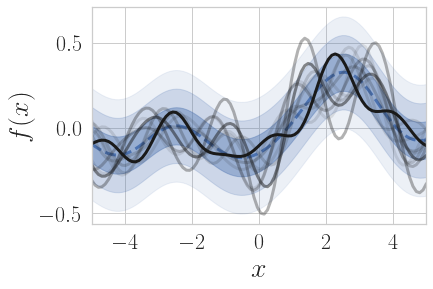

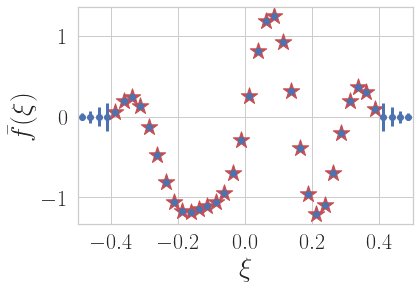

In [5]:
num_samples = 10
stride = 100
eps = 0.025
k = gp.kernels.SquaredExponential()

x = lab.expand_dims(lab.linspace(-5, 5, 100), axis=-1)
freqs = lab.expand_dims(lab.linspace(0.0001, .5, 2000), axis=-1)
z = lab.expand_dims(lab.range(int((2000-cut)/stride)) * eps + eps/2, axis=-1)
feats_cos = lab.cos(2*math.pi*z  *lab.squeeze(x))/lab.sqrt(freqs.shape[0])
feats_sin = lab.sin(2*math.pi*z * lab.squeeze(x))/lab.sqrt(freqs.shape[0])
v_cos = lab.sum(feats_cos * lab.squeeze(data), axis=-1)
v_sin = lab.sum(feats_sin * lab.squeeze(data), axis=-1)
ys = []

print(eps *lab.sum(vff.objectives.gaussian_spectral_density(k, z)))
# plot mean and confidences

std = lab.sqrt(k.K_diag(x) - 2*eps *lab.sum(vff.objectives.gaussian_spectral_density(k, z)))
feats_cos =  lab.cos(2*math.pi*z  *lab.squeeze(x))
feats_sin = lab.sin(2*math.pi*z * lab.squeeze(x))
mean = lab.sum(eps* (math.sqrt(2)*lab.expand_dims(v_cos, axis=-1) * feats_cos +
                     math.sqrt(2)*lab.expand_dims(v_sin, axis=-1) * feats_sin), 
               axis=0)
print(mean.shape)
seaborn.lineplot(x=lab.squeeze(x), y=lab.squeeze(mean), color='b', linestyle='dashed')
plt.fill_between(x=lab.squeeze(x), y1=mean-std, y2=mean+std, color='b', alpha=0.4)
plt.fill_between(x=lab.squeeze(x), y1=mean-2*std, y2=mean++2*std, color='b', alpha=0.2)
plt.fill_between(x=lab.squeeze(x), y1=mean-3*std, y2=mean++3*std, color='b', alpha=0.1)

s = lab.expand_dims(vff.objectives.gaussian_spectral_density(k, z), axis=-1)
C = lab.concat( lab.sqrt(2) * feats_cos, lab.sqrt(2)* feats_sin, axis=0)
kbar = lab.diag(lab.concat(vff.objectives.gaussian_spectral_density(k, z), 
                           vff.objectives.gaussian_spectral_density(k, z),
                          axis=0))
cov = k.K(x, x) - eps * lab.transpose(C) @ kbar @ C
for i in range(num_samples):
    seaborn.lineplot(x=lab.squeeze(x), y=mean+lab.squeeze(lab.chol(cov) @ lab.randn(cov.shape[-1], 1)), 
                                                     color='k', alpha=1/(i+1))
plt.xlim(x.min(), x.max())
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
plt.savefig('../images/if_x.png', bbox_inches="tight")

plt.show()
plt.clf()



# plot inducing points
plt.scatter(x=lab.squeeze(z), y = lab.squeeze(v_cos + v_sin), color='r', marker='*', s=300)
plt.scatter(x=-lab.squeeze(z), y=lab.squeeze(v_cos - v_sin), color='r', marker='*', s=300)

# and the means = inducing points
plt.scatter(x=lab.squeeze(z), y = lab.squeeze(v_cos + v_sin), color='b', marker='o')
plt.scatter(x=-lab.squeeze(z), y=lab.squeeze(v_cos - v_sin), color='b', marker='o')
# finally show the uncertainty at the edges 
edge_points = lab.range(int(cut/stride)) * eps + z[-1, 0] + eps
edge_points = lab.concat(edge_points, -edge_points)
plt.errorbar(x=edge_points, y = np.zeros(edge_points.shape[-1]), 
             yerr = 2*vff.objectives.gaussian_spectral_density(k, lab.expand_dims(edge_points, axis=-1)), fmt='o', color='b')

plt.xlim(-freqs.max(), freqs.max())
plt.xlabel(r'$\xi$')
plt.ylabel(r'$\bar{f}(\xi)$')
plt.savefig('../images/iff_xi.png', bbox_inches="tight")
